In [16]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas_datareader.data as web


# DATA 
we'll use the Fama and French data publically available on their website 

In [2]:
Symbol="F-F_Research_Data_5_Factors_2x3"

ds = web.DataReader(Symbol, 'famafrench',start='1800')
print(ds['DESCR'])
data=ds[0]
data.index=data.index.to_timestamp()
rf=data.iloc[:,[-1]]
data=data.iloc[:,:-1]

F-F Research Data 5 Factors 2x3
-------------------------------

This file was created by CMPT_ME_BEME_OP_INV_RETS using the 202004 CRSP database. The 1-month TBill return is from Ibbotson and Associates Inc.

  0 : (682 rows x 6 cols)
  1 : Annual Factors: January-December (56 rows x 6 cols)


In [3]:
Symbol="F-F_Momentum_Factor"
ds1 = web.DataReader(Symbol, 'famafrench',start='1800')
print(ds1['DESCR'])
mom=ds1[0]
mom.index=mom.index.to_timestamp()
data=pd.concat((data,mom),axis=1,join='inner')

F-F Momentum Factor
-------------------

This file was created by CMPT_ME_PRIOR_RETS using the 202004 CRSP database. It contains a momentum factor, constructed from six value-weight portfolios formed using independent sorts on size and prior return of NYSE, AMEX, and NASDAQ stocks. Mom  is the average of the returns on two (big and small) high prior return portfolios minus the average of the returns on two low prior return portfolios. The portfolios are constructed monthly. Big means a firm is above the median market cap on the NYSE at the end of the previous month; small firms are below the median NYSE market cap. Prior return is measured from month -12 to - 2. Firms in the low prior return portfolio are below the 30th NYSE percentile. Those in the high portfolio are above the 70th NYSE percentile. Missing data are indicated by -99.99 or -999. Copyright 2020 Kenneth R. French

  0 : (1120 rows x 1 cols)
  1 : Annual Factors: January-December (93 rows x 1 cols)


In [4]:
Symbol="F-F_ST_Reversal_Factor"
ds1 = web.DataReader(Symbol, 'famafrench',start='1800')
print(ds1['DESCR'])
ST_Reversal=ds1[0]
ST_Reversal.index=ST_Reversal.index.to_timestamp()
data=pd.concat((data,ST_Reversal),axis=1,join='inner')

F-F ST Reversal Factor
----------------------

This file was created by CMPT_ME_PRIOR_RETS using the 202004 CRSP database. It contains a momentum factor, constructed from six value-weight portfolios formed using independent sorts on size and prior return of NYSE, AMEX, and NASDAQ stocks. ST_Rev is the average of the returns on two (big and small) low prior return portfolios minus the average of the returns on two high prior return portfolios. The portfolios are constructed monthly. Big means a firm is above the median market cap on the NYSE at the end of the previous month; small firms are below the median NYSE market cap. Prior return is measured from month - 1 to - 1. Firms in the low prior return portfolio are below the 30th NYSE percentile. Those in the high portfolio are above the 70th NYSE percentile. Missing data are indicated by -99.99 or -999. Copyright 2020 Kenneth R. French

  0 : (1131 rows x 1 cols)
  1 : Annual Factors: January-December (93 rows x 1 cols)


In [5]:
Symbol="F-F_LT_Reversal_Factor"
ds1 = web.DataReader(Symbol, 'famafrench',start='1800')
print(ds1['DESCR'])
LT_Reversal=ds1[0]
LT_Reversal.index=LT_Reversal.index.to_timestamp()
data=pd.concat((data,LT_Reversal),axis=1,join='inner')

F-F LT Reversal Factor
----------------------

This file was created by CMPT_ME_PRIOR_RETS using the 202004 CRSP database. It contains a momentum factor, constructed from six value-weight portfolios formed using independent sorts on size and prior return of NYSE, AMEX, and NASDAQ stocks. LT_Rev is the average of the returns on two (big and small) low prior return portfolios minus the average of the returns on two high prior return portfolios. The portfolios are constructed monthly. Big means a firm is above the median market cap on the NYSE at the end of the previous month; small firms are below the median NYSE market cap. Prior return is measured from month -60 to -13. Firms in the low prior return portfolio are below the 30th NYSE percentile. Those in the high portfolio are above the 70th NYSE percentile. Missing data are indicated by -99.99 or -999. Copyright 2020 Kenneth R. French

  0 : (1072 rows x 1 cols)
  1 : Annual Factors: January-December (89 rows x 1 cols)


# Using Reinforcement Learning To pick Factors

In [6]:
data['equally weighted']=data.mean(axis=1)

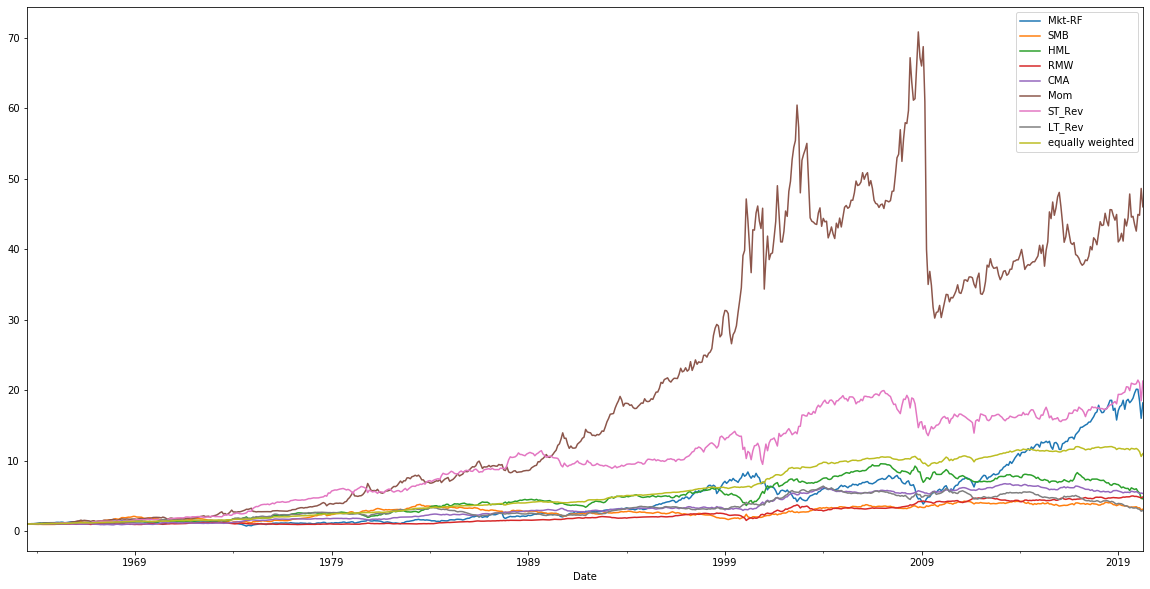

In [7]:
(data/100+1).cumprod().plot(figsize=(20,10))

In [15]:
def sharpe_ratio(x):
    mu, sigma = 12 * x.mean(), np.sqrt(12 * x.var())
    values = np.array([mu, sigma, mu / sigma]).squeeze()
    index = ['mu', 'sigma', 'SR']
    return pd.DataFrame(values, index=index,columns=x.columns)

In [9]:
sharpe_ratio(data)

,Mkt-RF,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,equally weighted
mu,6.317419,2.539707,3.176481,3.059472,3.188094,7.854721,5.981173,2.264164,4.297654
sigma,15.403706,10.471287,9.943466,7.464028,6.901977,14.524149,10.903969,8.762350,3.834901
SR,0.410123,0.242540,0.319454,0.409896,0.461910,0.540804,0.548532,0.258397,1.120669


### EWA (Exponentially weighted Algorithm) : 
for <b> K</b> portfolios to choose from and a Horizon of investment <b>T</b>, we choose the portfolio weights as follows : 
$$w_{t+1}(k)=\frac{e^{-\eta \sum_{s=1}^{t} g_{s}(k)}}{\sum_{j=1}^{K} e^{-\eta \sum_{s=1}^{t} g_{s}(j)}}$$
$$\eta=\sqrt{\frac{\log K}{ T}}$$

In [14]:
factors=data.loc[:,:'LT_Rev']
losses=(-factors/100).add((factors/100).max(axis=1),axis=0)
#losses=-(factors/100)
K=losses.shape[1]
T=12*10 #losses.shape[0]
eta =np.sqrt(np.log(K)/T) 
cum_loss=np.exp(-eta*losses.cumsum())
weights=cum_loss.divide(cum_loss.sum(axis=1),axis=0)
weights=weights.shift(1)
weights.iloc[0,:]=1/K
data['EWA']=(factors*weights).sum(axis=1)
sharpe_ratio(data)

,Mkt-RF,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,equally weighted,EWA,window EWA
mu,6.317419,2.539707,3.176481,3.059472,3.188094,7.854721,5.981173,2.264164,4.297654,4.374381,4.329809
sigma,15.403706,10.471287,9.943466,7.464028,6.901977,14.524149,10.903969,8.762350,3.834901,3.892673,3.836976
SR,0.410123,0.242540,0.319454,0.409896,0.461910,0.540804,0.548532,0.258397,1.120669,1.123747,1.128443


One parameters that needs to be tuned is $\eta$ , this can be solved used the <b> doubling trick </b> : 
every timestep $T_i=2^i$ we use $\eta=\sqrt{\frac{\log K}{ T_i}}$, we'll also use a rolling window of <b> 10 years </b> to compute the cumulative loss of each factor portfolio 


In [12]:
factors=data.loc[:,:'LT_Rev']
losses=(-factors/100).add((factors/100).max(axis=1),axis=0)
#losses=-(factors/100)
K=losses.shape[1]
#T=12 #losses.shape[0]

#Implementing The Doubling Trick for etha
K=data.loc[:,:'LT_Rev'].shape[1]
etas=pd.DataFrame(index=range(1,data.shape [0]+1))
etas['eta']=np.nan
ti=[2**i for i in range(10)]
etas.loc[ti,'eta']=np.sqrt(np.log(K)/ti)
etas=etas.ffill()
eta=etas.values.ravel()


window=12*10
#eta = 0.5*np.sqrt(np.log(K)/T) 
cum_loss=losses.rolling(window).sum()
cum_loss.iloc[:window]=losses.cumsum().iloc[:window]
#cum_loss=np.exp(-eta*cum_loss)
cum_loss=np.exp(cum_loss.multiply(-eta,axis=0))
weights=cum_loss.divide(cum_loss.sum(axis=1),axis=0)
weights=weights.shift(1)
weights.iloc[0,:]=1/K
data['window EWA']=(factors*weights).sum(axis=1)
sharpe_ratio(data)

,Mkt-RF,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,equally weighted,EWA,window EWA
mu,6.317419,2.539707,3.176481,3.059472,3.188094,7.854721,5.981173,2.264164,4.297654,4.335636,4.329809
sigma,15.403706,10.471287,9.943466,7.464028,6.901977,14.524149,10.903969,8.762350,3.834901,3.855353,3.836976
SR,0.410123,0.242540,0.319454,0.409896,0.461910,0.540804,0.548532,0.258397,1.120669,1.124576,1.128443


We can see How our portfolios created using EWA  outperform the equally weighted portfolio and all the other portfolios as well . 